## Tutorial of indirect objective identification with DAS

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/align-transformers/blob/main/tutorials/Indirect%20object%20identification%20(IOI)%20circuit%20with%20DAS.ipynb)

In [1]:
__author__ = "Zhengxuan Wu"
__version__ = "11/15/2023"

### Overview

This tutorial tries to reproduce some of the key results in [this paper](https://arxiv.org/pdf/2311.17030.pdf) using this library. It tries to localize name position information with additional streams beside `mlp_activation` as well as `block_output`. We can sort of seeing where information emerges throughout the network.

### Set-up

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import transformers
    import sys
    sys.path.append("align-transformers/")
except ModuleNotFoundError:
    !git clone https://github.com/frankaging/align-transformers.git
    !pip install -r align-transformers/requirements.txt
    import sys
    sys.path.append("align-transformers/")

In [3]:
import sys
sys.path.append("../..")

import pandas as pd
from tutorial_ioi_utils import *
from models.utils import embed_to_distrib, top_vals, format_token
from models.configuration_alignable_model import AlignableRepresentationConfig, AlignableConfig
from models.alignable_base import AlignableModel
from models.interventions import LowRankRotatedSpaceIntervention
from models.gpt2.modelings_alignable_gpt2 import create_gpt2_lm

%config InlineBackend.figure_formats = ['svg']
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text, \
                     geom_bar, geom_hline, scale_y_log10, scale_y_reverse, scale_fill_cmap, geom_text, \
                     scale_fill_gradient, geom_point, geom_line, theme_minimal, ylim

def single_d_low_rank_das_position_config(
    model_type, intervention_type, layer, alignable_interventions_type,
    alignable_low_rank_dimension=1, num_unit=1, head_level=False
):
    alignable_config = AlignableConfig(
        alignable_model_type=model_type,
        alignable_representations=[
            AlignableRepresentationConfig(
                layer,             # layer
                intervention_type, # intervention type
                "pos" if not head_level else "h.pos",
                num_unit,
                alignable_low_rank_dimension=alignable_low_rank_dimension, # a single das direction
            ),
        ],
        alignable_interventions_type=alignable_interventions_type,
    )
    return alignable_config

criterion = torch.nn.CrossEntropyLoss()
# You can define your custom compute_metrics function.
def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        actual_test_labels = eval_label
        pred_test_labels = torch.argmax(eval_pred[:, -1], dim=-1)
        correct_labels = (actual_test_labels==pred_test_labels)
        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
    accuracy = round(correct_count/total_count, 2)
    return {"accuracy" : accuracy}

def calculate_loss(logits, labels):
    shift_logits = logits[..., -1, :].contiguous()
    shift_labels = labels.contiguous()
    # Flatten the tokens
    shift_logits = shift_logits
    shift_labels = shift_labels.view(-1)
    # Enable model parallelism
    shift_labels = shift_labels.to(shift_logits.device)
    loss = criterion(shift_logits, shift_labels)

    return loss

def find_name_position_at(positions, layers, stream, heads=None, debug=False):
    
    if debug:
        print(f"finding name position at: pos->{positions}, layers->{layers}, stream->{stream}")
    
    data = []

    batch_size = 20
    eval_every = 5
    initial_lr = 0.01
    n_epochs = 10
    aligning_stream = stream

    for aligning_pos in positions:
        for aligning_layer in layers:
            if heads is not None:
                alignable_config = single_d_low_rank_das_position_config(
                    type(gpt2), aligning_stream, aligning_layer, LowRankRotatedSpaceIntervention,
                    alignable_low_rank_dimension=1, num_unit=len(heads), head_level=True
                )
            else:
                alignable_config = single_d_low_rank_das_position_config(
                    type(gpt2), aligning_stream, aligning_layer, LowRankRotatedSpaceIntervention,
                    alignable_low_rank_dimension=1
                )
            alignable = AlignableModel(alignable_config, gpt2)
            alignable.set_device("cuda")
            alignable.disable_model_gradients()
            
            optimizer = torch.optim.Adam(alignable.get_trainable_parameters(), lr=initial_lr)
            scheduler = torch.optim.lr_scheduler.LinearLR(
                optimizer, end_factor=0.1, total_iters=n_epochs
            )

            total_step = 0
            for epoch in range(n_epochs):
                torch.cuda.empty_cache()
                for batch_dataset in D_train.batches(batch_size=batch_size):
                    # prepare base
                    base_inputs = batch_dataset.base.tokens
                    b_s = base_inputs["input_ids"].shape[0]
                    for k, v in base_inputs.items():
                        if v is not None and isinstance(v, torch.Tensor):
                            base_inputs[k] = v.to(gpt2.device)
                    # prepare source
                    source_inputs = batch_dataset.source.tokens
                    for k, v in source_inputs.items():
                        if v is not None and isinstance(v, torch.Tensor):
                            source_inputs[k] = v.to(gpt2.device)
                    # prepare label
                    labels = batch_dataset.patched_answer_tokens[:,0].to(gpt2.device)

                    assert all(x==18 for x in batch_dataset.base.lengths)
                    assert all(x==18 for x in batch_dataset.source.lengths)
                    
                    if heads is not None:
                        _, counterfactual_outputs = alignable(
                            {"input_ids": base_inputs["input_ids"]},
                            [{"input_ids": source_inputs["input_ids"]}],
                            {"sources->base": (
                                [
                                    [[heads]*b_s, [[aligning_pos]]*b_s]
                                ], 
                                [
                                    [[heads]*b_s, [[aligning_pos]]*b_s]
                                ]
                            )}
                        )
                    else:
                        _, counterfactual_outputs = alignable(
                            {"input_ids": base_inputs["input_ids"]},
                            [{"input_ids": source_inputs["input_ids"]}],
                            {"sources->base": ([[[aligning_pos]]*b_s], [[[aligning_pos]]*b_s])}
                        )

                    eval_metrics = compute_metrics([counterfactual_outputs.logits], [labels])
                    loss = calculate_loss(counterfactual_outputs.logits, labels)
                    loss_str = round(loss.item(), 2)
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    alignable.set_zero_grad()
                    total_step += 1

            # eval
            eval_labels = []
            eval_preds = []
            with torch.no_grad():
                torch.cuda.empty_cache()
                for batch_dataset in D_test.batches(batch_size=batch_size):
                    # prepare base
                    base_inputs = batch_dataset.base.tokens
                    b_s = base_inputs["input_ids"].shape[0]
                    for k, v in base_inputs.items():
                        if v is not None and isinstance(v, torch.Tensor):
                            base_inputs[k] = v.to(gpt2.device)
                    # prepare source
                    source_inputs = batch_dataset.source.tokens
                    for k, v in source_inputs.items():
                        if v is not None and isinstance(v, torch.Tensor):
                            source_inputs[k] = v.to(gpt2.device)
                    # prepare label
                    labels = batch_dataset.patched_answer_tokens[:,0].to(gpt2.device)

                    assert all(x==18 for x in batch_dataset.base.lengths)
                    assert all(x==18 for x in batch_dataset.source.lengths)

                    if heads is not None:
                        _, counterfactual_outputs = alignable(
                            {"input_ids": base_inputs["input_ids"]},
                            [{"input_ids": source_inputs["input_ids"]}],
                            {"sources->base": (
                                [
                                    [[heads]*b_s, [[aligning_pos]]*b_s]
                                ], 
                                [
                                    [[heads]*b_s, [[aligning_pos]]*b_s]
                                ]
                            )}
                        )
                    else:
                        _, counterfactual_outputs = alignable(
                            {"input_ids": base_inputs["input_ids"]},
                            [{"input_ids": source_inputs["input_ids"]}],
                            {"sources->base": ([[[aligning_pos]]*b_s], [[[aligning_pos]]*b_s])}
                        )
                    eval_labels += [labels]
                    eval_preds += [counterfactual_outputs.logits]
            eval_metrics = compute_metrics(eval_preds, eval_labels)
            if heads is not None:
                heads_str = ",".join([str(h) for h in heads])
                data.append({
                    "pos":aligning_pos,
                    "layer":aligning_layer,
                    "acc":eval_metrics['accuracy'],
                    "stream":f"{stream}_{heads_str}"
                })
            else:
                data.append({
                    "pos":aligning_pos,
                    "layer":aligning_layer,
                    "acc":eval_metrics['accuracy'],
                    "stream":stream
                })
    return data

[2023-12-19 12:08:32,342] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


### Load dataset

Dataset creation is copied from [this repo](https://github.com/amakelov/activation-patching-illusion).

In [4]:
transformers.set_seed(42)

config, tokenizer, gpt2 = create_gpt2_lm(cache_dir="../../../.huggingface_cache")
_ = gpt2.eval().to("cuda")

D_train = train_distribution.sample_das(
    tokenizer=tokenizer,
    base_patterns=['ABB', 'BAB'],
    source_patterns=['ABB', 'BAB'],
    labels='position',
    samples_per_combination=50,
)
D_test = test_distribution.sample_das(
    tokenizer=tokenizer,
    base_patterns=['ABB',],
    source_patterns=['BAB'],
    labels='position',
    samples_per_combination=50,
) + test_distribution.sample_das(
    tokenizer=tokenizer,
    base_patterns=['BAB',],
    source_patterns=['ABB'],
    labels='position',
    samples_per_combination=50,
)

loaded model


### Factual recall

In [5]:
total_count = 0
correct_count = 0
with torch.no_grad():
    for batch_dataset in D_train.batches(batch_size=30):
        inputs = batch_dataset.base.tokens

        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(gpt2.device)
        labels = batch_dataset.base.answer_tokens[:,0].to(gpt2.device)

        outputs = gpt2(**inputs)

        pred_labels = outputs.logits.argmax(dim=-1)[:,-1]
        correct_labels = (labels==pred_labels)

        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
current_acc = round(correct_count/total_count, 2)
print(f"gpt-2 IOI task accuracy: {current_acc}")

gpt-2 IOI task accuracy: 0.96


### Localizing in the main residual stream

In [37]:
block_out_data = find_name_position_at([13, 14, 15, 16, 17], [i for i in range(12)], "block_output")

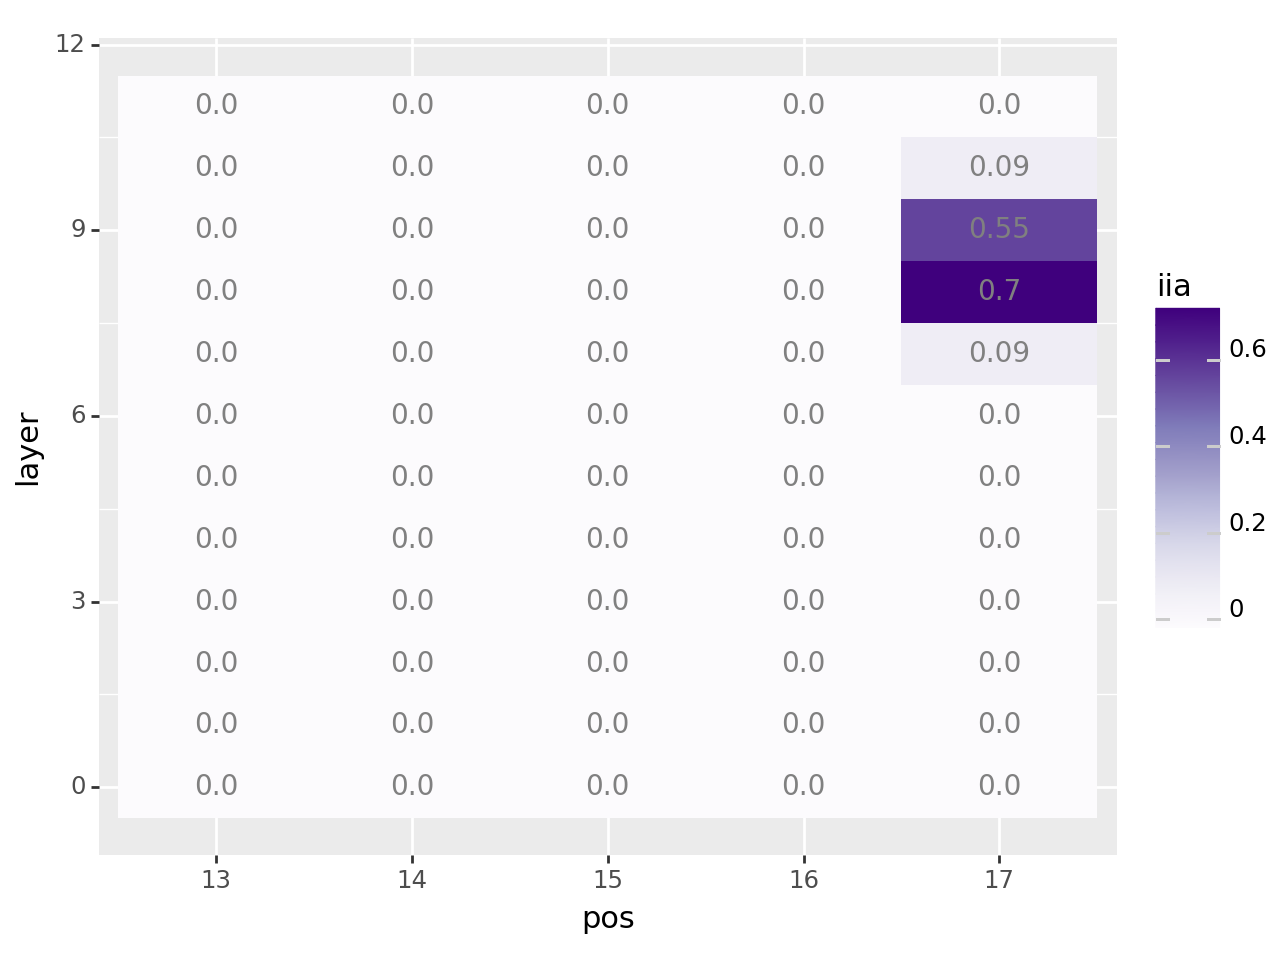

In [19]:
df = pd.DataFrame(block_out_data)
df["layer"] = df["layer"].astype(int)
df["pos"] = df["pos"].astype(int)
df["iia"] = df["acc"].astype(float)
df['pos'] = df['pos'].astype('category')

plot = (ggplot(df, aes(x="pos", y="layer"))
        + geom_tile(aes(fill="iia")) + scale_fill_cmap("Purples")
        + geom_text(aes(label=round(df["acc"], 2)), color="grey", size=10))
print(plot)

### Localizing in different streams

In [9]:
attn_input_data = find_name_position_at([17], [i for i in range(12)], "attention_input")
block_input_data = find_name_position_at([17], [i for i in range(12)], "block_input")
mlp_input_data = find_name_position_at([17], [i for i in range(12)], "mlp_input")
mlp_act_data = find_name_position_at([17], [i for i in range(12)], "mlp_activation")
attn_out_data = find_name_position_at([17], [i for i in range(12)], "attention_output")
mlp_out_data = find_name_position_at([17], [i for i in range(12)], "mlp_output")
attn_value_out_data = find_name_position_at([17], [i for i in range(12)], "attention_value_output")
block_output_data = find_name_position_at([17], [i for i in range(12)], "block_output")

finding name position at: pos->[17], layers->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], stream->attention_input
finding name position at: pos->[17], layers->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], stream->block_input
finding name position at: pos->[17], layers->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], stream->mlp_input
finding name position at: pos->[17], layers->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], stream->mlp_activation
finding name position at: pos->[17], layers->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], stream->attention_output
finding name position at: pos->[17], layers->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], stream->mlp_output
finding name position at: pos->[17], layers->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], stream->attention_value_output


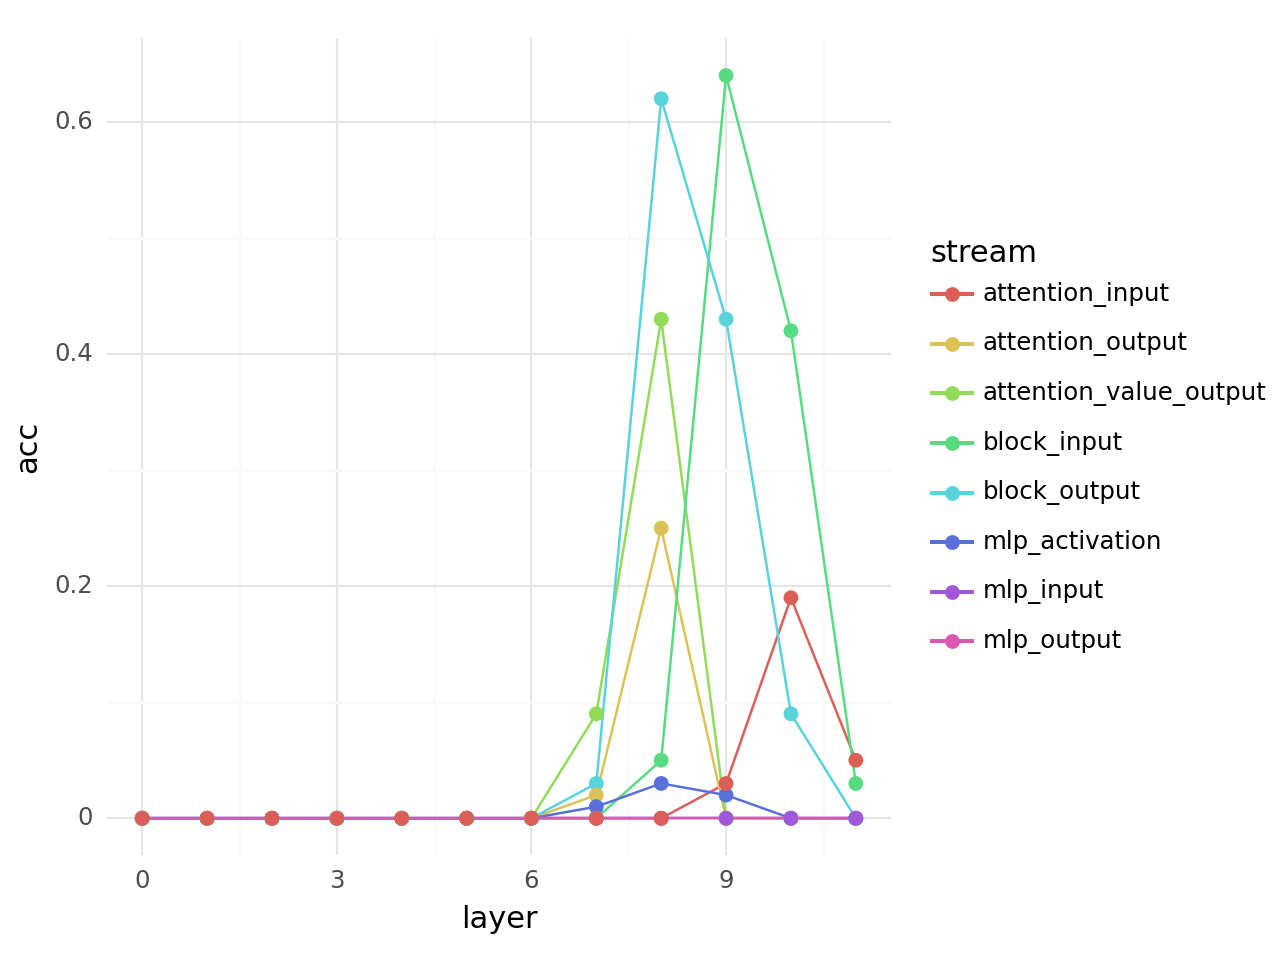

In [13]:
df = pd.DataFrame(
    block_output_data+attn_out_data+mlp_out_data+attn_value_out_data+mlp_act_data+mlp_input_data+block_input_data+attn_input_data
)

plot = (
    ggplot(df, aes(x="layer", y="acc", color="stream")) +
    geom_line() +
    geom_point(size=2) +
    theme_minimal()
)

print(plot)

### Localizing in each individual head at layer 8

In [16]:
head_attn_value_out_data = []
for h in range(12):
    _head_attn_value_out_data = find_name_position_at(
        [17], [i for i in range(12)], "head_attention_value_output", [h])
    head_attn_value_out_data.extend(_head_attn_value_out_data)

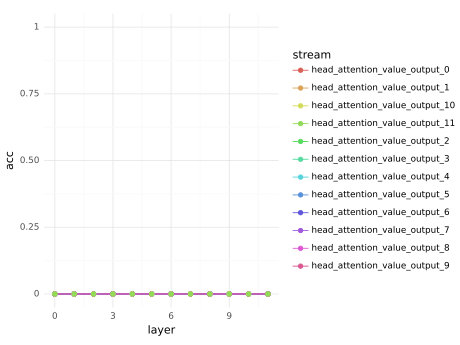

In [20]:
df = pd.DataFrame(head_attn_value_out_data)

plot = (
    ggplot(df, aes(x="layer", y="acc", color="stream")) +
    geom_line() +
    geom_point(size=2) +
    theme_minimal() +
    ylim(0, 1)
)

print(plot)

### Localizing with group of heads using rankings of missing out head IIA

In [23]:
head_attn_value_out_mo_data = []
for i in range(12):
    print("evaluating grouped IIA without head", i)
    _head_attn_value_out_mo_data = find_name_position_at(
        [17], [8], "head_attention_value_output", 
        heads=list(set([i for i in range(12)]) - {i})
    )[0]
    _head_attn_value_out_mo_data["mo_head"] = i
    head_attn_value_out_mo_data += [_head_attn_value_out_mo_data]

evaluating grouped IIA without head 0
evaluating grouped IIA without head 1
evaluating grouped IIA without head 2
evaluating grouped IIA without head 3
evaluating grouped IIA without head 4
evaluating grouped IIA without head 5
evaluating grouped IIA without head 6
evaluating grouped IIA without head 7
evaluating grouped IIA without head 8
evaluating grouped IIA without head 9
evaluating grouped IIA without head 10
evaluating grouped IIA without head 11


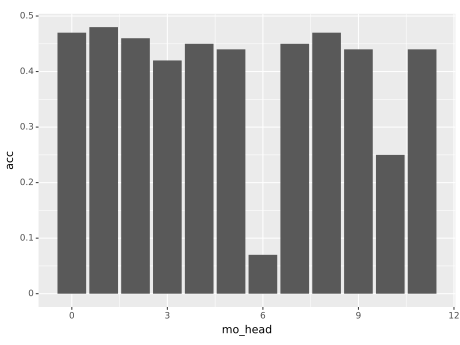

In [28]:
df = pd.DataFrame(head_attn_value_out_mo_data)

plot = (
    ggplot(df, aes(x="mo_head", y="acc")) +
    geom_bar(stat="identity", position="dodge")
)

print(plot)

In [8]:
find_name_position_at(
    [17], [8], "head_attention_value_output", 
    heads=[6,10,3,11,5,9,4,7,2] 
    # although 6 and 10 carry the most info, it is fairly distributed across these heads
)

[{'pos': 17,
  'layer': 8,
  'acc': 0.44,
  'stream': 'head_attention_value_output_6,10,3,11,5,9,4,7,2'}]